In [8]:
# %load_ext autoreload
# %autoreload 2 

import matplotlib.pyplot as plt
import rpd_utils as rpd

POPULATION_SIZE = 50
N_GENERATIONS = 1000
GENOME_LENGTH = rpd.GENOME_LENGTH # Should be 16

ROUNDS_PER_GAME = 100  # Number of rounds in a single RPD game
N_OPPONENTS_TO_PLAY = 10 # Each individual plays against N other individuals for fitness evaluation

TOURNAMENT_K = 5       # Size of tournament for selection
ELITE_SIZE = 2          # Number of best individuals to carry to next generation
MUTATION_RATE = 0.1    # Probability of mutating a single gene
MUTATION_STRENGTH = 0.1 # Std deviation for Gaussian mutation
CROSSOVER_ALPHA = 0.2   # Crossover alpha for blend crossover

COMPATIBILITY_THRESHOLD = 2.0 # Genomic distance threshold for speciation (tune this)
ENABLE_SPECIATION = True

VERBOSITY = 100 # How often to print the status of the evolution process

population, avg_raw_score_history, best_raw_score_history, avg_fitness_history, num_species_history, population_diversity_history = rpd.run_evolution(POPULATION_SIZE, N_GENERATIONS, N_OPPONENTS_TO_PLAY, ROUNDS_PER_GAME, ELITE_SIZE, TOURNAMENT_K, MUTATION_RATE, MUTATION_STRENGTH, CROSSOVER_ALPHA, COMPATIBILITY_THRESHOLD, VERBOSITY)

Generation 1/1000
Avg Raw Score: 0.09, Best Raw Score: 2.45
Avg Fitness: 0.05, Num Species: 3
Population Diversity: 1.51
Generation 101/1000
Avg Raw Score: 0.06, Best Raw Score: 1.51
Avg Fitness: 0.00, Num Species: 1
Population Diversity: 0.43
Generation 201/1000
Avg Raw Score: 0.04, Best Raw Score: 1.10
Avg Fitness: 0.00, Num Species: 1
Population Diversity: 0.38
Generation 301/1000
Avg Raw Score: 0.04, Best Raw Score: 1.13
Avg Fitness: 0.00, Num Species: 1
Population Diversity: 0.31
Generation 401/1000
Avg Raw Score: 0.04, Best Raw Score: 1.08
Avg Fitness: 0.00, Num Species: 1
Population Diversity: 0.45
Generation 501/1000
Avg Raw Score: 0.05, Best Raw Score: 1.23
Avg Fitness: 0.00, Num Species: 1
Population Diversity: 0.40
Generation 601/1000
Avg Raw Score: 0.07, Best Raw Score: 1.65
Avg Fitness: 0.00, Num Species: 1
Population Diversity: 0.33
Generation 701/1000
Avg Raw Score: 0.06, Best Raw Score: 1.44
Avg Fitness: 0.00, Num Species: 1
Population Diversity: 0.32
Generation 801/100

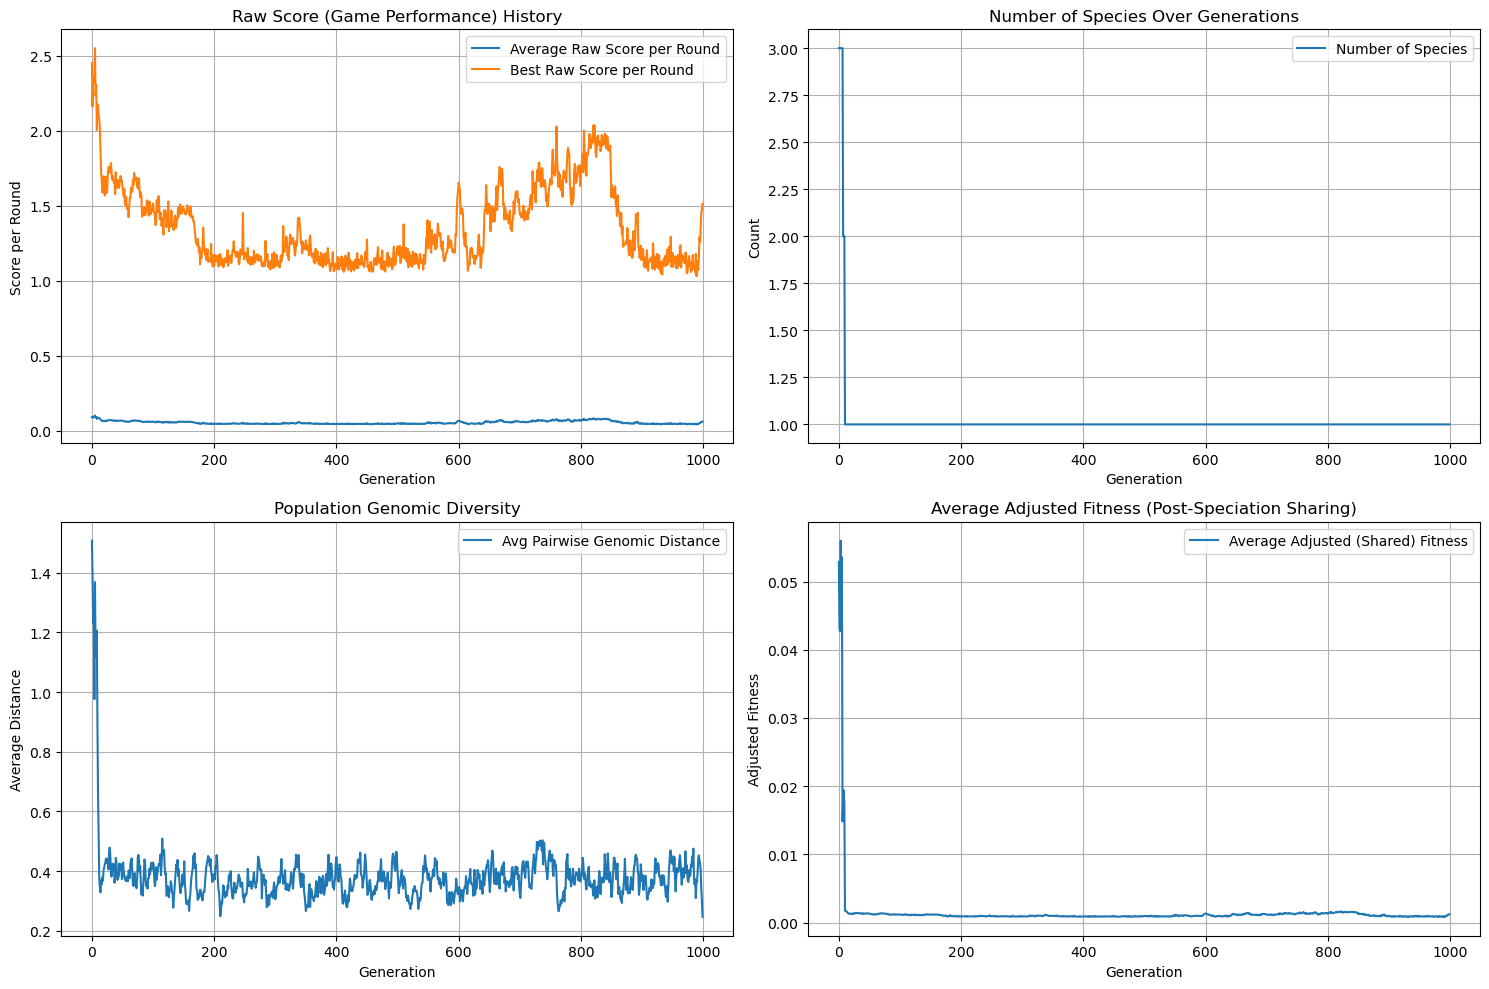

In [9]:
# --- Plotting Results ---
plt.figure(figsize=(15, 10))

# Plot 1: Fitness History (Raw Score)
plt.subplot(2, 2, 1)
plt.plot(avg_raw_score_history, label="Average Raw Score per Round")
plt.plot(best_raw_score_history, label="Best Raw Score per Round")
plt.xlabel("Generation")
plt.ylabel("Score per Round")
plt.title("Raw Score (Game Performance) History")
plt.legend()
plt.grid(True)

# Plot 2: Number of Species
plt.subplot(2, 2, 2)
plt.plot(num_species_history, label="Number of Species")
plt.xlabel("Generation")
plt.ylabel("Count")
plt.title("Number of Species Over Generations")
plt.legend()
plt.grid(True)

# Plot 3: Population Diversity
plt.subplot(2, 2, 3)
plt.plot(population_diversity_history, label="Avg Pairwise Genomic Distance")
plt.xlabel("Generation")
plt.ylabel("Average Distance")
plt.title("Population Genomic Diversity")
plt.legend()
plt.grid(True)

# Plot 4: Adjusted Fitness (if speciation enabled)
if ENABLE_SPECIATION:
    plt.subplot(2, 2, 4)
    plt.plot(avg_fitness_history, label="Average Adjusted (Shared) Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Adjusted Fitness")
    plt.title("Average Adjusted Fitness (Post-Speciation Sharing)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
# --- Analysis of Evolved Strategies ---
print("\n--- Analysis of Final Population ---")
population.sort(key=lambda ind: ind.avg_score_per_round, reverse=True) # Sort by raw game performance

print("\nBest 5 individuals (by raw score):")
for i in range(min(5, len(population))):
    ind = population[i]
    print(f"Individual {ind.id}: Raw Score: {ind.avg_score_per_round:.3f}, Species: {ind.species_id}")
    # print(f"  Genome (P(Cooperate) for 16 states): {np.round(ind.genome, 2)}")
    # For easier reading, let's map history states to their P(Cooperate)
    print("  Strategy Highlights (P(Cooperate)):")
    # History state: (My_t-1, My_t-2, Opp_t-1, Opp_t-2)
    # Example states:
    # (C,C,C,C) -> (0,0,0,0) -> index 0
    # (D,D,D,D) -> (1,1,1,1) -> index 15
    # (C,C,D,D) -> (0,0,1,1) -> index 3 (I was cooperating, opponent defected twice)
    # (D,C,C,C) -> (1,0,0,0) -> index 8 (I defected after cooperating, opponent cooperated)
    
    hist_cc_cc_idx = rpd.get_history_index([rpd.COOPERATE, rpd.COOPERATE], [rpd.COOPERATE, rpd.COOPERATE]) # My C,C; Opp C,C
    hist_cd_cd_idx = rpd.get_history_index([rpd.COOPERATE, rpd.DEFECT], [rpd.COOPERATE, rpd.DEFECT]) # My C,D; Opp C,D (Tit-for-Tat like response)
    hist_dd_dd_idx = rpd.get_history_index([rpd.DEFECT, rpd.DEFECT], [rpd.DEFECT, rpd.DEFECT]) # My D,D; Opp D,D
    hist_cc_dd_idx = rpd.get_history_index([rpd.COOPERATE, rpd.COOPERATE], [rpd.DEFECT, rpd.DEFECT]) # My C,C; Opp D,D (Sucker)
    hist_dd_cc_idx = rpd.get_history_index([rpd.DEFECT, rpd.DEFECT], [rpd.COOPERATE, rpd.COOPERATE]) # My D,D; Opp C,C (Temptation exploited)


    print(f"    P(C | My C,C; Opp C,C): {ind.genome[hist_cc_cc_idx]:.2f} (Idx {hist_cc_cc_idx})")
    print(f"    P(C | My C,C; Opp D,D): {ind.genome[hist_cc_dd_idx]:.2f} (Idx {hist_cc_dd_idx})")
    print(f"    P(C | My D,D; Opp C,C): {ind.genome[hist_dd_cc_idx]:.2f} (Idx {hist_dd_cc_idx})")
    print(f"    P(C | My D,D; Opp D,D): {ind.genome[hist_dd_dd_idx]:.2f} (Idx {hist_dd_dd_idx})")


--- Analysis of Final Population ---

Best 5 individuals (by raw score):
Individual 50000: Raw Score: 1.512, Species: 49950
  Strategy Highlights (P(Cooperate)):
    P(C | My C,C; Opp C,C): 0.01 (Idx 0)
    P(C | My C,C; Opp D,D): 0.45 (Idx 3)
    P(C | My D,D; Opp C,C): 0.44 (Idx 12)
    P(C | My D,D; Opp D,D): 0.06 (Idx 15)
Individual 50001: Raw Score: 1.477, Species: 49950
  Strategy Highlights (P(Cooperate)):
    P(C | My C,C; Opp C,C): 0.00 (Idx 0)
    P(C | My C,C; Opp D,D): 0.45 (Idx 3)
    P(C | My D,D; Opp C,C): 0.45 (Idx 12)
    P(C | My D,D; Opp D,D): 0.14 (Idx 15)
Individual 50002: Raw Score: 0.000, Species: None
  Strategy Highlights (P(Cooperate)):
    P(C | My C,C; Opp C,C): 0.01 (Idx 0)
    P(C | My C,C; Opp D,D): 0.45 (Idx 3)
    P(C | My D,D; Opp C,C): 0.44 (Idx 12)
    P(C | My D,D; Opp D,D): 0.06 (Idx 15)
Individual 50003: Raw Score: 0.000, Species: None
  Strategy Highlights (P(Cooperate)):
    P(C | My C,C; Opp C,C): 0.01 (Idx 0)
    P(C | My C,C; Opp D,D): 0.46 